### Process to adjust bright field images to timed video based on light sheet imaging time stamps. by Hikaru Shishido ver3.00
 明視野画像をライトシート顕微鏡の撮像タイミングに基づいて、調整する処理  

#### How to use 
- Change Folder path
- Put the following four files in the Folder specified above.
- ① 3Dtimestamp.csv, ② log.csv, ③ parameter.txt, ④ rec.avi

#### 使用方法 
- Folder pathを変更
- 上記で指定のFolderに以下4つのファイルを入れた状態にする
- ① 3Dtimestamp.csv, ② log.csv, ③ parameter.txt, ④ rec.avi

In [1]:
folder_paths = [
    r"C:\Users\Mikami\Desktop\.img\20240508-185610tdTomato-10mW-1 good\20240508185004"
]

1 / 7: Finihed to read start_time from parameter.txt
2 / 7: Finihed to calucurate lightsheet timestamp
9996
重複はありません
3 / 7: Finihed to get bright image's frame number
4 / 7: Finihed to make video
5 / 7: Finihed to make log file
6 / 7: Finihed to make summary csv file
7 / 7: Finihed to make velocity plot




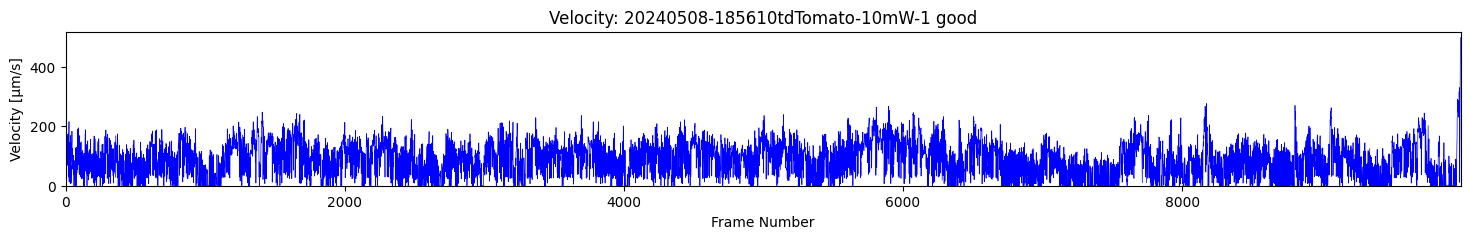

All process is finished


In [12]:
import sys, cv2, csv, winsound, os
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter

fps = 50
origin_folder_path = os.path.abspath(os.path.join(folder_paths[0], "..\.."))
summary_csv_path = os.path.join(origin_folder_path, "Local velocity-summary.csv")

for h in range(len(folder_paths)):
    mathching_video_filename = "rec matching " + str(fps) + " fps.avi"
    matching_log_filename = "log matching " + str(fps) + " fps.csv"

    # Lightsheet csv file's path
    lightsheet_csv_path = folder_paths[h] + "/" + "3Dtimestamp.csv"
    # bright image csv file's path
    log_bright = folder_paths[h] + "/" + "log.csv"
    # parameter txt file's path
    txt_path = folder_paths[h] + "/" + "parameter.txt"
    # video's path
    video_path = folder_paths[h] + "/" + "rec.avi"

    ################################################
    # read start_time from parameter txt file "parameter.txt"
    ################################################
    with open(txt_path, 'r') as file:
        lines = file.readlines()

    txt_data = {}
    for line in lines:
        key, value = line.strip().split(':', 1)
        txt_data[key.strip()] = value.strip()

    # start_time
    start_time = float(txt_data['start_time'])

    print("1 / 7: Finihed to read start_time from parameter.txt")

    ################################################
    # calucurate lightsheet timestamp with csv file "3Dtimestamp.csv" and start_time
    ################################################
    lightsheet_RawTime = []
    lightsheet_time = []

    with open(lightsheet_csv_path, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter='\t')
        for row in csvreader:
            lightsheet_RawTime.extend(map(float, row))
    raw_Lenghth = len(lightsheet_RawTime)

    for i in range(raw_Lenghth):
        if i == 0:
            pass
        else:
            if lightsheet_RawTime[i-1] > lightsheet_RawTime[i]:
                lightsheet_RawTime[i] = lightsheet_RawTime[i] + lightsheet_RawTime[i+1]/1000
                lightsheet_RawTime.pop(i+1)
                print(f"CSV file have Error at {i}th timestamp")
    Lenghth = len(lightsheet_RawTime)

    for i in range(Lenghth):
        if i == 0:
            lightsheet_time.append(start_time)
        else:
            lightsheet_time.append(lightsheet_time[i-1] + lightsheet_RawTime[i] - lightsheet_RawTime[i-1])

    print("2 / 7: Finihed to calucurate lightsheet timestamp")

    ################################################
    # get bright image's frame number which is match with lightsheet timestamp
    ################################################
    mylist = []
    prev_row = [0, 0]

    with open(log_bright, "r", encoding="shift_jis") as csv_bright:
        csvR_bright = csv.reader(csv_bright)
        header = next(csvR_bright)

        for i in range(Lenghth):
            time_fluore = lightsheet_time[i]

            for row in csvR_bright:
                time_bright = row[1]
                if float(time_fluore) <= float(time_bright):
                    
                    now = abs(float(time_fluore) - float(row[1]))
                    prev = abs(float(time_fluore) - float(priv_row[1])) if prev_row[0] != 0 else now + 1
                    if prev < now:
                        mylist.append(priv_row[0])
                        priv_row = [0, 0]
                    else:
                        mylist.append(row[0])
                        priv_row = row
                    break
                
    print(len(mylist))
    if len(mylist) == len(set(mylist)):
        print("重複はありません")
    else:
        print("重複があります")

    print("3 / 7: Finihed to get bright image's frame number")

    ################################################
    # make video which is match with lightsheet timestamp
    ################################################
    n = 0; m = 0
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("failed to open video")
        sys.exit()

    is_image, img = cap.read()
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(folder_paths[h]+"/"+mathching_video_filename, fourcc, fps, (img.shape[1], img.shape[0]))

    while True:
        if is_image:
            if n < len(mylist):
                if int(mylist[n]) == m:
                    n += 1
                    try:
                        writer.write(img)
                    except:
                        print("failed to write video")
                        sys.exit()
            else:
                break
            m += 1
        else:
            break

        is_image, img = cap.read()

    cap.release()
    writer.release()
    csv_bright.close()
    csvfile.close()

    print("4 / 7: Finihed to make video")

    ################################################
    # make log file which is match with lightsheet timestamp
    ################################################

    mylist_int = [int(x) for x in mylist]

    with open(log_bright, 'r', newline='', encoding="shift_jis") as input_file, open(folder_paths[h] + "/" + matching_log_filename, 'w', newline='', encoding="shift_jis") as output_file:
        reader = csv.reader(input_file)
        writer = csv.writer(output_file)
        writer.writerow(["frame","timestamp","stageX[pulse]","stageY[pulse]",
                        "Δt[s]","Δd[μm]","velocity[μm/s]","detectionX[pixel]","detectionY[pixel]",
                        "gap_x[pixel]","gap_y[pixel]","gap_x[μm]","gap_y[μ]","gap_x[pulse]","gap_y[pulse]",
                        "error[μm]","kal_x[pixel]","kal_y[pixel]","radius[pixel]","asobi[pixel]"])

        for i, row in enumerate(reader):
            if i in mylist_int:
                writer.writerow(row)

    print("5 / 7: Finihed to make log file")
        
    ################################################
    # make summary csv file
    ################################################

    df = pd.read_csv(folder_paths[h] + "/" + matching_log_filename, encoding='shift_jis')
    column_data = df['velocity[μm/s]']

    # それぞれの条件を満たす値の数を数える
    count_0_to_100 = ((0 <= column_data) & (column_data < 100)).sum()
    count_100_to_200 = ((100 <= column_data) & (column_data < 200)).sum()
    count_200_to_300 = ((200 <= column_data) & (column_data < 300)).sum()
    count_300_to_400 = ((300 <= column_data) & (column_data < 400)).sum()
    count_400_over = (400 <= column_data).sum()

    # 結果を新しいDataFrameにまとめる
    result_df = pd.DataFrame({
        'Category': ['0 <= x < 100', '100 <= x < 200', '200 <= x < 300', '300 <= x < 400', '400 <= x'],
        'Count': [count_0_to_100, count_100_to_200, count_200_to_300, count_300_to_400, count_400_over]
    })

    # 新しいCSVファイルに書き出す
    parts = folder_paths[h].split(os.path.sep)
    extracted_string = [part for part in parts if "tdTomato" in part][0]

    mode = 'w' if h == 0 else 'a'
    with open(summary_csv_path, mode=mode) as f:
        f.write(f"{extracted_string}\n")
    result_df.to_csv(summary_csv_path, mode='a', index=False)
    with open(summary_csv_path, 'a') as f:
        f.write("\n") 

    print("6 / 7: Finihed to make summary csv file")

    ################################################
    # plot velocity
    ################################################

    # グラフの縦幅と横幅を設定
    plt.figure(figsize=(18, 2))

    # インデックスをx軸、値をy軸として折れ線グラフを描画
    plt.plot(column_data, color='blue', linewidth=0.5) 

    # x軸とy軸の範囲を設定して原点を合わせる
    plt.xlim(0, len(column_data) - 1)  # x軸の範囲を0からデータポイント数-1に設定
    plt.ylim(min(column_data), max(column_data)+20)  # y軸の範囲を最小値から最大値に設定

    # グラフにタイトルやラベルを追加する場合
    plt.title(f'Velocity: {extracted_string}') 
    plt.xlabel('Frame Number')
    plt.ylabel('Velocity [μm/s]')

    # 画像として保存
    fig_path = os.path.join(origin_folder_path, f"Local velocity-{extracted_string}.png")
    plt.savefig(fig_path)

    print("7 / 7: Finihed to make velocity plot")
    print("\n")
    # グラフを表示
    plt.show()

print("All process is finished")
winsound.Beep(1000, 200)